In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
#Set notebook preferences
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
#Load modules
os.chdir('/Users/ksharma/Documents/ML Engineer/Machine Learning/Projects/paysim_credit_fraud_analysis/')
from src.data.import_export_data import load_config

#Import data
path= r'/Users/ksharma/Documents/ML Engineer/Machine Learning/Projects/paysim_credit_fraud_analysis/'
config_name= 'config.yaml'

config= load_config(config_name= config_name, path=path)

dtypes= {'isFraud':'bool', 'isFlaggedFraud':'bool', 'step':'object'}
rawData= pd.read_csv(config['paths']['rawData'] + 'RawCreditTransactionData.csv', dtype=dtypes)

**Data Overview**

In [4]:
display(rawData.shape)
display(rawData.head())

(6362620, 11)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,False,False
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,False,False
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,True,False
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,True,False
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,False,False


**Heat Map**

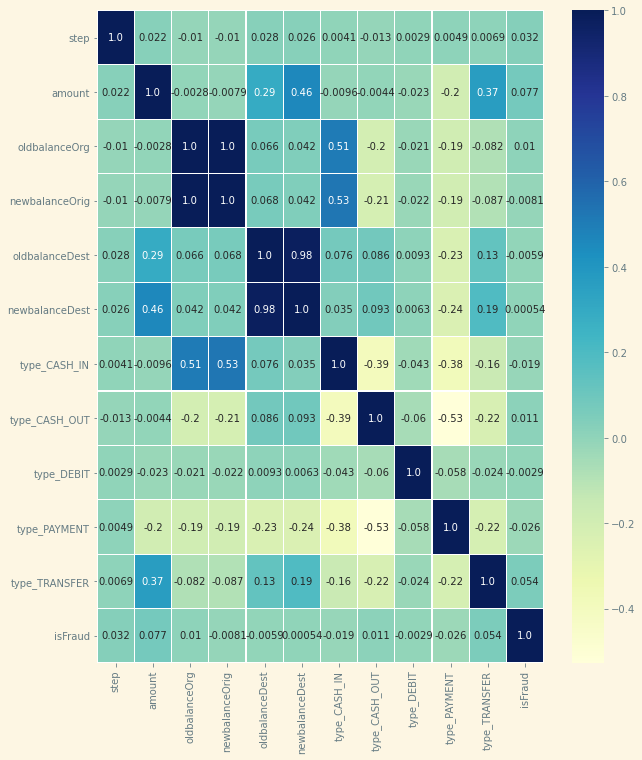

In [5]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(config['paths']['figures'] +'HeatMap.png')

# Preprocessing

**Data Cleaning**
- Removing string cols: nameOrig, nameDest
- Drop previous model predictions and export as CSV for later

In [6]:
#Create copy
processedData= rawData.copy()
processedData.drop(columns= ['nameOrig', 'nameDest','isFlaggedFraud'], axis=1, inplace= True)

#Check
display(processedData.head())

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.640,170136.000,160296.360,0.000,0.000,False
1,1,PAYMENT,1864.280,21249.000,19384.720,0.000,0.000,False
2,1,TRANSFER,181.000,181.000,0.000,0.000,0.000,True
3,1,CASH_OUT,181.000,181.000,0.000,21182.000,0.000,True
4,1,PAYMENT,11668.140,41554.000,29885.860,0.000,0.000,False


In [7]:
#Subset model predictions and target, export to CSV
previousPredictions= rawData.loc[:, ['isFraud', 'isFlaggedFraud']]

previousPredictions.to_csv(config['paths']['cleanedData'] + 'previousModelPredictions.csv')

**Check for Multicollinearity**

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#Remove object and bools
vifData= processedData.select_dtypes(exclude= ['bool', 'object'])

#init Stats_Check object and view VIF scores
from src.models.processing import Stats_Tests
test1= Stats_Tests(vifData)
test1.add_constant()
test1.VIF_analysis()

amount             3.704
oldbalanceOrg    430.053
newbalanceOrig   431.094
oldbalanceDest    64.982
newbalanceDest    74.888
const              1.250
dtype: float64

In [9]:
#Drop cols with highest collinearity and re-evaluate VIF scores
test1.drop_cols(columns= ['newbalanceOrig', 'newbalanceDest'])
test1.VIF_analysis()

amount           1.095
oldbalanceOrg    1.005
oldbalanceDest   1.100
const            1.224
dtype: float64

**Update processedData for Export**

In [10]:
#Get column names to subset from test1
test1Cols=list(test1.data.columns)
test1Cols.pop()
test1Cols

['amount', 'oldbalanceOrg', 'oldbalanceDest']

In [11]:
#Subset cols to export final dataframe
processedDataCols= list(processedData.select_dtypes(include=['object', 'bool']).columns)
updatedCols= test1Cols + processedDataCols
updatedCols.sort()

In [12]:
toExportCsv= processedData[updatedCols]

#Check
display(toExportCsv.head())

,amount,isFraud,oldbalanceDest,oldbalanceOrg,step,type
0,9839.640,False,0.000,170136.000,1,PAYMENT
1,1864.280,False,0.000,21249.000,1,PAYMENT
2,181.000,True,0.000,181.000,1,TRANSFER
3,181.000,True,21182.000,181.000,1,CASH_OUT
4,11668.140,False,0.000,41554.000,1,PAYMENT
...,...,...,...,...,...,...
6362615,339682.130,True,0.000,339682.130,743,CASH_OUT
6362616,6311409.280,True,0.000,6311409.280,743,TRANSFER
6362617,6311409.280,True,68488.840,6311409.280,743,CASH_OUT
6362618,850002.520,True,0.000,850002.520,743,TRANSFER


### Export Processed Data

In [13]:
from src.data.import_export_data import save_csv
save_csv(toExportCsv, path= config['paths']['cleanedData'], filename= 'processedData.csv')

'File successfully written to path'